In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

In [2]:
# Things to try:
# try larger network
# better normalization with batchnorm
# different lrs
# change architecture to a CNN

In [3]:
IMG_SIZE = 28

In [4]:

class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.dis = nn.Sequential(
            nn.Conv2d(3,32,5,stride=2,padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(32,64,5,stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64,128,5,stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2,inplace=True),
        )
        self.dis2 = nn.Sequential(
            nn.Linear(3*28*28,256),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(256,512),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(512,1),
            nn.Sigmoid(),
        )
     
    def forward(self, x,shape=False):
        x = x.view(-1,3,IMG_SIZE,IMG_SIZE)
        x = self.dis(x)
        if shape:
            print(x.shape)
        x = x.view(-1,3*28*28)
        x = self.dis2(x)
        return x


class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
 
        self.gen = nn.Sequential(
            nn.Linear(z_dim,256),
            nn.ReLU(inplace=True),
            nn.Linear(256,512),
            nn.ReLU(inplace=True),
            nn.Linear(512,1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048,IMG_SIZE*IMG_SIZE*3),
            nn.Tanh()
        )
 
    def forward(self, x):
        return self.gen(x)

In [ ]:
# HYPERPARAMS
device = 'cuda'
lr = 3e-4
z_dim = 64 # 128,256,32 # I dont know what is z_dim but I know that that is a parameter at least :)
image_dim = 28*28*1 # 784
batch_size = 32
num_epochs = 25
disc = Discriminator(image_dim).to(device)
gen = Generator(z_dim,image_dim).to(device)
fixed_noise = torch.randn((batch_size,z_dim)).to(device)
transforms = transforms.Compose(
    [transforms.ToTensor(),transforms.Normalize((0.4),(0.4))]
)
dataset = datasets.MNIST(root='dataset/',transform=transforms,download=True)
loader = DataLoader(dataset,batch_size=batch_size,shuffle=True)
opt_disc = optim.Adam(disc.parameters(),lr=lr)
opt_gen = optim.Adam(gen.parameters(),lr=lr)
criterion = nn.BCELoss()
writer_fake = SummaryWriter(f'runs/GAN_MNIST/fake')
writer_real = SummaryWriter(f'runs/GAN_MNIST/real')
step = 0

In [ ]:
fixed_noise.shape

In [ ]:
lossGs = []
lossDs = []

In [8]:
for epoch in tqdm(range(num_epochs)):
    for batch_idx,(real,_) in enumerate(loader):
        real = real.view(-1,28*28).to(device)
        batch_size = real.shape[0]
        noise = torch.randn(batch_size,z_dim).to(device)
        fake = gen(noise)
        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real,torch.ones_like(disc_real))
        disc_fake = disc(fake).view(-1) 
        lossD_fake = criterion(disc_fake,torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()
        output = disc(fake).view(-1)
        lossG = criterion(output,torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()
        if batch_idx == 0:
            print(f'Epoch : [{epoch}/{num_epochs}] \n Loss D : {lossD:.4f}, Loss G : {lossG:.4f}')
            with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1,1,28,28)
                data = real.reshape(-1,1,28,28)
                img_grid_fake = torchvision.utils.make_grid(fake,normalize=True)
                img_grid_real = torchvision.utils.make_grid(data,normalize=True)
                writer_fake.add_image('Mnist Fake Imgs',img_grid_fake,global_step=step)
                writer_real.add_image('Mnist Real Imgs',img_grid_real,global_step=step)
                step += 1
                lossGs.append(lossG.item())
                lossDs.append(lossD.item())

  0%|          | 0/25 [00:00<?, ?it/s]


RuntimeError: shape '[-1, 3, 28, 28]' is invalid for input of size 25088

In [35]:
for epoch in tqdm(range(num_epochs)):
    for batch_idx,(real,_) in enumerate(loader):
        real = real.view(-1,28*28).to(device)
        batch_size = real.shape[0]
        # Train Discriminator
        noise = torch.randn(batch_size,z_dim).to(device)
#         print(real.shape) # real image
#         print(noise.shape) # 
        fake = gen(noise)
#         print(fake.shape) # the fake image
        disc_real = disc(real).view(-1)
#         print(disc_real) # so like is this real or fake probability
        lossD_real = criterion(disc_real,torch.ones_like(disc_real))
        disc_fake = disc(fake).view(-1) 
#         print(disc_fake) # so like is this real or fake probability|
        lossD_fake = criterion(disc_fake,torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()
        # Train generator
        output = disc(fake).view(-1)
#         print(output) # so we are checking how good the gen here and in the above one we are checking for disc this is the same output
        lossG = criterion(output,torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()
        if batch_idx == 0:
            print(f'Epoch : [{epoch}/{num_epochs}] \n Loss D : {lossD:.4f}, Loss G : {lossG:.4f}')
            with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1,1,28,28)
                data = real.reshape(-1,1,28,28)
                img_grid_fake = torchvision.utils.make_grid(fake,normalize=True)
                img_grid_real = torchvision.utils.make_grid(data,normalize=True)
                writer_fake.add_image('Mnist Fake Imgs',img_grid_fake,global_step=step)
                writer_real.add_image('Mnist Real Imgs',img_grid_real,global_step=step)
                step += 1
                lossGs.append(lossG.item())
                lossDs.append(lossD.item())

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch : [0/25] 
 Loss D : 0.7292, Loss G : 0.7161


  4%|▍         | 1/25 [00:14<05:40, 14.17s/it]

Epoch : [1/25] 
 Loss D : 0.6296, Loss G : 1.4521


  8%|▊         | 2/25 [00:28<05:24, 14.09s/it]

Epoch : [2/25] 
 Loss D : 0.4810, Loss G : 1.2263


 12%|█▏        | 3/25 [00:42<05:10, 14.11s/it]

Epoch : [3/25] 
 Loss D : 0.2740, Loss G : 2.0254


 16%|█▌        | 4/25 [00:56<04:55, 14.09s/it]

Epoch : [4/25] 
 Loss D : 0.2269, Loss G : 3.2157


 20%|██        | 5/25 [01:10<04:41, 14.09s/it]

Epoch : [5/25] 
 Loss D : 0.3387, Loss G : 2.6382


 24%|██▍       | 6/25 [01:24<04:27, 14.08s/it]

Epoch : [6/25] 
 Loss D : 0.2840, Loss G : 2.3787


 28%|██▊       | 7/25 [01:38<04:13, 14.06s/it]

Epoch : [7/25] 
 Loss D : 0.1310, Loss G : 2.8315


 32%|███▏      | 8/25 [01:52<03:59, 14.08s/it]

Epoch : [8/25] 
 Loss D : 0.3180, Loss G : 2.4057


 36%|███▌      | 9/25 [02:06<03:45, 14.09s/it]

Epoch : [9/25] 
 Loss D : 0.2359, Loss G : 3.0677


 40%|████      | 10/25 [02:20<03:31, 14.10s/it]

Epoch : [10/25] 
 Loss D : 0.2878, Loss G : 2.0956


 44%|████▍     | 11/25 [02:35<03:17, 14.09s/it]

Epoch : [11/25] 
 Loss D : 0.2609, Loss G : 2.4456


 48%|████▊     | 12/25 [02:49<03:03, 14.08s/it]

Epoch : [12/25] 
 Loss D : 0.2478, Loss G : 2.5218


 52%|█████▏    | 13/25 [03:03<02:48, 14.08s/it]

Epoch : [13/25] 
 Loss D : 0.2588, Loss G : 2.5472


 56%|█████▌    | 14/25 [03:17<02:34, 14.07s/it]

Epoch : [14/25] 
 Loss D : 0.1806, Loss G : 2.6412


 60%|██████    | 15/25 [03:31<02:20, 14.05s/it]

Epoch : [15/25] 
 Loss D : 0.2695, Loss G : 2.8935


 64%|██████▍   | 16/25 [03:45<02:06, 14.04s/it]

Epoch : [16/25] 
 Loss D : 0.2078, Loss G : 2.4469


 68%|██████▊   | 17/25 [03:59<01:52, 14.04s/it]

Epoch : [17/25] 
 Loss D : 0.2504, Loss G : 3.1408


 72%|███████▏  | 18/25 [04:13<01:38, 14.06s/it]

Epoch : [18/25] 
 Loss D : 0.2420, Loss G : 2.9814


 76%|███████▌  | 19/25 [04:27<01:24, 14.07s/it]

Epoch : [19/25] 
 Loss D : 0.2477, Loss G : 2.7778


 80%|████████  | 20/25 [04:41<01:10, 14.07s/it]

Epoch : [20/25] 
 Loss D : 0.1493, Loss G : 3.1178


 84%|████████▍ | 21/25 [04:55<00:56, 14.05s/it]

Epoch : [21/25] 
 Loss D : 0.1220, Loss G : 2.6995


 88%|████████▊ | 22/25 [05:09<00:42, 14.04s/it]

Epoch : [22/25] 
 Loss D : 0.2345, Loss G : 4.1012


 92%|█████████▏| 23/25 [05:23<00:28, 14.05s/it]

Epoch : [23/25] 
 Loss D : 0.1090, Loss G : 3.6073


 96%|█████████▌| 24/25 [05:37<00:14, 14.08s/it]

Epoch : [24/25] 
 Loss D : 0.1066, Loss G : 3.7009


100%|██████████| 25/25 [05:51<00:00, 14.07s/it]


In [36]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [37]:
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 33060), started 8:10:57 ago. (Use '!kill 33060' to kill it.)

In [38]:
import matplotlib.pyplot as plt

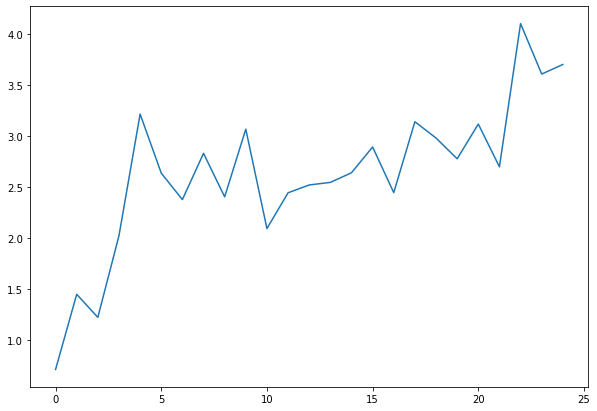

In [39]:
plt.figure(figsize=(10,7))
plt.plot(lossGs)
plt.show()

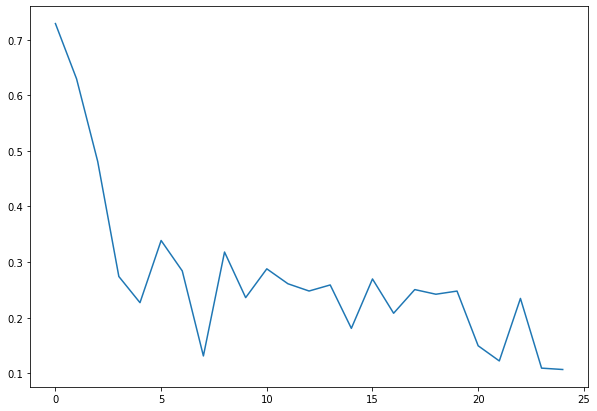

In [40]:
plt.figure(figsize=(10,7))
plt.plot(lossDs)
plt.show()

In [41]:
# baseline = ok
# new model 1 = ok
# new model 2 = ok
# new model 3 = 